In [1]:
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import Compose
from torch_geometric.data import Data

import os,sys

In [3]:
## check if EOS folder exists otherwise use local folder
GraphDIR = "../../data/Graphs_v240725_241113/"

graph_name = 'vix_graph_13Nov_3_muonQOverPt' #"vix_graph_13Nov_3_muonQOverPt" #vix_graph_6Nov_3_muonQOverPt
#"vix_graph_13Nov_3_muonQOverPt" #vix_graph_6Nov_3_muonQOverPt
num_files = 20
all_files = os.listdir(GraphDIR)

# Filter for .pkl files
graph_files_nov = [f for f in all_files if (f.endswith('.pkl') or f.endswith('.pt')) and graph_name in f]
if not graph_files_nov:
    print("No .pkl/.pt files found in the directory.")
    sys.exit()

graph_files_nov = graph_files_nov[:num_files]

graphs_nov = []
for graph_file in graph_files_nov:
    file_path = os.path.join(GraphDIR, graph_file)
    print(f"Loading file: {graph_file}")
    if graph_file.endswith('.pt'):
        graph = torch.load(file_path, weights_only=False)
    elif graph_file.endswith('.pkl'):
        with open(file_path, 'rb') as file:
            graph = torch.load(file)
    graphs_nov.append(graph)


Loading file: vix_graph_13Nov_3_muonQOverPt_001.pt
Loading file: vix_graph_13Nov_3_muonQOverPt_002.pt
Loading file: vix_graph_13Nov_3_muonQOverPt_003.pt
Loading file: vix_graph_13Nov_3_muonQOverPt_004.pt
Loading file: vix_graph_13Nov_3_muonQOverPt_005.pt
Loading file: vix_graph_13Nov_3_muonQOverPt_006.pt
Loading file: vix_graph_13Nov_3_muonQOverPt_007.pt
Loading file: vix_graph_13Nov_3_muonQOverPt_008.pt
Loading file: vix_graph_13Nov_3_muonQOverPt_009.pt


In [4]:
Graphs_for_training_nov = sum(graphs_nov, [])
print(f"Total Graphs: {len(Graphs_for_training_nov)}")

### NOW FILTER EMPTY GRAPHS... 
Graphs_for_training_reduced = Graphs_for_training_nov
Graphs_for_training_filtered_nov = [
    g for g in Graphs_for_training_reduced
    if not (torch.isnan(g.y).any() or torch.isnan(g.x).any())  and g.edge_index.size(1) > 0
]

# remove extra dimension in y and put deltaPhi and deltaEta in the data object as edge_attr
for i in range(0, len(Graphs_for_training_filtered_nov)):
    Graphs_for_training_filtered_nov[i].y = Graphs_for_training_filtered_nov[i].y.mean(dim=0)
    Graphs_for_training_filtered_nov[i].edge_attr = torch.stack([Graphs_for_training_filtered_nov[i].deltaPhi.float(), Graphs_for_training_filtered_nov[i].deltaEta.float()], dim=1)        

Graphs_for_training_filtered_nov = [
    g for g in Graphs_for_training_filtered_nov
    if not (torch.isnan(g.x).any() or torch.isnan(g.edge_attr).any() or torch.isnan(g.y).any())
]

print(f"Filtered Graphs: {len(Graphs_for_training_filtered_nov)}")


Total Graphs: 507314
Filtered Graphs: 502362


In [7]:
# Now load the Graphs from may: 
#all_files = os.listdir("../../data/Graphs_v250514_250617_MuGun_FullEta_OneOverPt_1to100_OmtfDataset_Jun17_regression_001.pt")
#graph_name = "OmtfDataset_May30_regression"
graph_files_may = ["../../data/Graphs_v250514_250617_MuGun_FullEta_OneOverPt_1to100_OmtfDataset_Jun17_regression_001.pt"]
#f for f in all_files if (f.endswith('.pkl') or f.endswith('.pt')) and graph_name in f]
if not graph_files_may:
    print("No .pkl/.pt files found in the directory.")
    sys.exit()

graphs_may = []
for graph_file in graph_files_may:
    file_path = os.path.join("../../data/Graphs_v250514_250530_MuGun_FullEta_OneOverPt_1to100/", graph_file)
    print(f"Loading file: {graph_file}")
    if graph_file.endswith('.pt'):
        graph = torch.load(file_path, weights_only=False)
    elif graph_file.endswith('.pkl'):
        with open(file_path, 'rb') as file:
            graph = torch.load(file)
    graphs_may.append(graph)

Loading file: ../../data/Graphs_v250514_250617_MuGun_FullEta_OneOverPt_1to100_OmtfDataset_Jun17_regression_001.pt


In [8]:
Graphs_for_training_may = sum(graphs_may, [])
print(f"Total Graphs: {len(Graphs_for_training_may)}")

### NOW FILTER EMPTY GRAPHS... 
Graphs_for_training_reduced = Graphs_for_training_may
Graphs_for_training_filtered_may = [
    g for g in Graphs_for_training_reduced
    if not (torch.isnan(g.y).any() or torch.isnan(g.x).any())  and g.edge_index.size(1) > 0
]

# remove extra dimension in y and put deltaPhi and deltaEta in the data object as edge_attr
for i in range(0, len(Graphs_for_training_filtered_may)):
    Graphs_for_training_filtered_may[i].y = Graphs_for_training_filtered_may[i].y.mean(dim=0)

Graphs_for_training_filtered_may = [
    g for g in Graphs_for_training_filtered_may
    if not (torch.isnan(g.x).any() or torch.isnan(g.edge_attr).any() or torch.isnan(g.y).any())
]

print(f"Filtered Graphs: {len(Graphs_for_training_filtered_may)}")


Total Graphs: 3266
Filtered Graphs: 3266


Dataset1 - Nodos: promedio = 5.804320390475394 min = 2 max = 11
Dataset2 - Nodos: promedio = 6.854562155541947 min = 3 max = 13
Dataset1 - Aristas: promedio = 18.87864926089155 min = 2 max = 56
Dataset2 - Aristas: promedio = 20.154317207593387 min = 2 max = 69


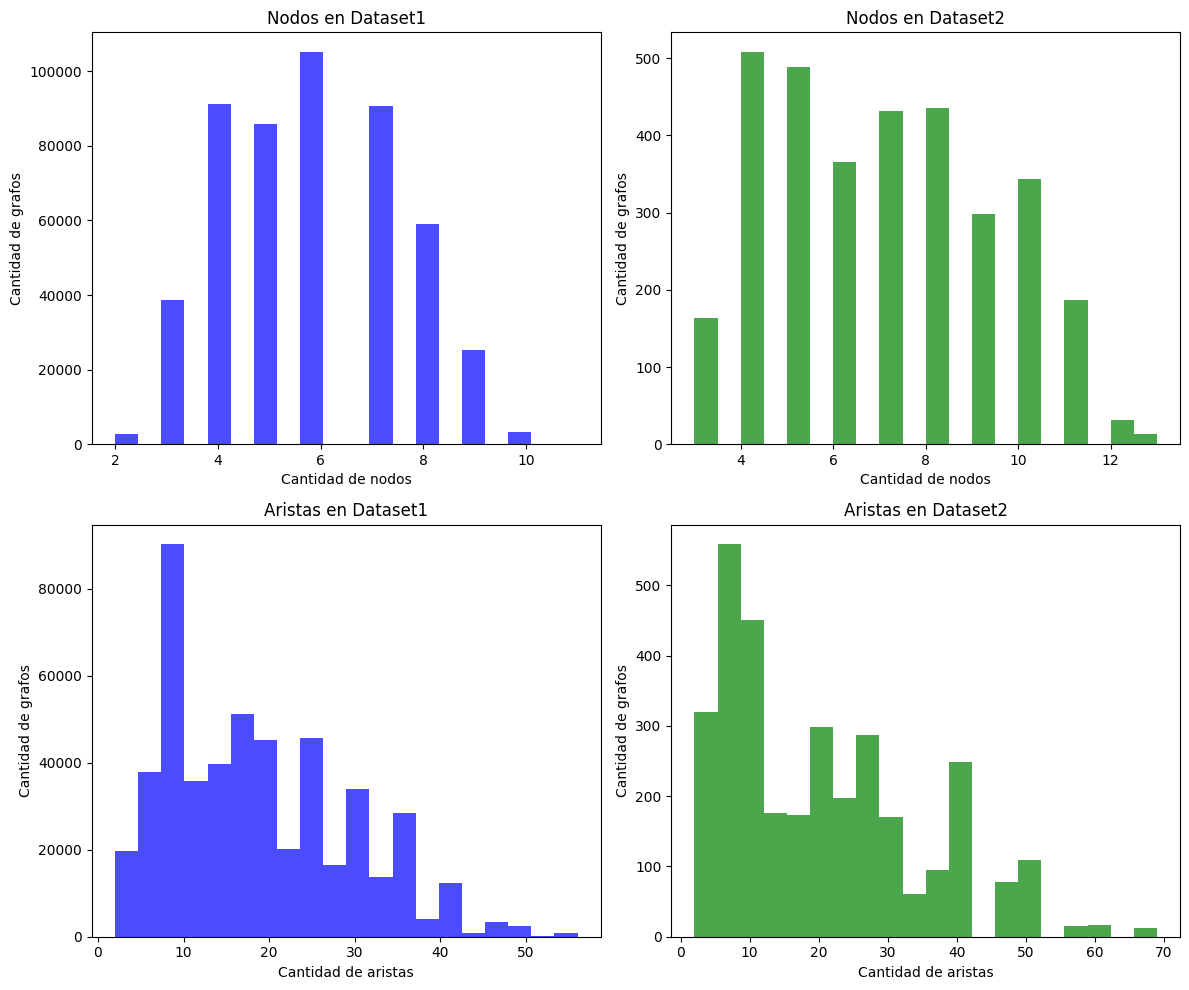

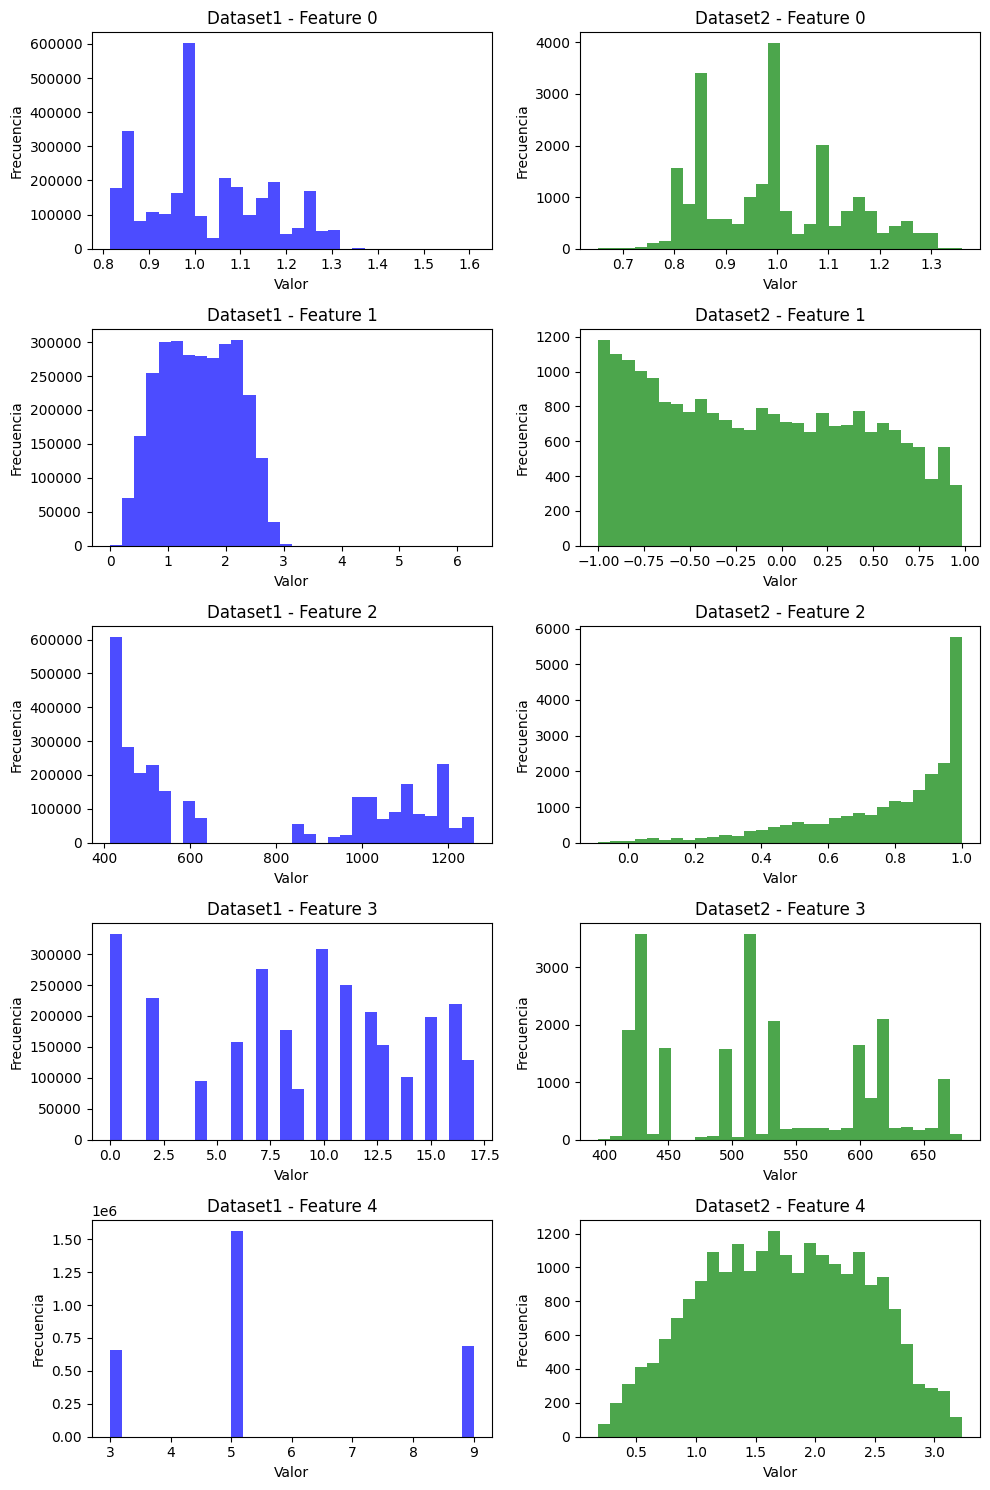

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def compare_datasets(dataset1, dataset2):
    # Extraer número de nodos y aristas en cada grafo
    nodes1 = [data.x.shape[0] for data in dataset1]
    nodes2 = [data.x.shape[0] for data in dataset2]
    edges1 = [data.edge_index.shape[1] for data in dataset1]
    edges2 = [data.edge_index.shape[1] for data in dataset2]
    
    # Mostrar estadísticas
    print("Dataset1 - Nodos: promedio =", np.mean(nodes1), "min =", np.min(nodes1), "max =", np.max(nodes1))
    print("Dataset2 - Nodos: promedio =", np.mean(nodes2), "min =", np.min(nodes2), "max =", np.max(nodes2))
    print("Dataset1 - Aristas: promedio =", np.mean(edges1), "min =", np.min(edges1), "max =", np.max(edges1))
    print("Dataset2 - Aristas: promedio =", np.mean(edges2), "min =", np.min(edges2), "max =", np.max(edges2))
    
    # Graficar histogramas de nodos y aristas
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    axs[0, 0].hist(nodes1, bins=20, color='blue', alpha=0.7)
    axs[0, 0].set_title('Nodos en Dataset1')
    axs[0, 0].set_xlabel('Cantidad de nodos')
    axs[0, 0].set_ylabel('Cantidad de grafos')
    
    axs[0, 1].hist(nodes2, bins=20, color='green', alpha=0.7)
    axs[0, 1].set_title('Nodos en Dataset2')
    axs[0, 1].set_xlabel('Cantidad de nodos')
    axs[0, 1].set_ylabel('Cantidad de grafos')
    
    axs[1, 0].hist(edges1, bins=20, color='blue', alpha=0.7)
    axs[1, 0].set_title('Aristas en Dataset1')
    axs[1, 0].set_xlabel('Cantidad de aristas')
    axs[1, 0].set_ylabel('Cantidad de grafos')
    
    axs[1, 1].hist(edges2, bins=20, color='green', alpha=0.7)
    axs[1, 1].set_title('Aristas en Dataset2')
    axs[1, 1].set_xlabel('Cantidad de aristas')
    axs[1, 1].set_ylabel('Cantidad de grafos')
    
    plt.tight_layout()
    plt.show()
    
    # Comparar la distribución de cada variable en x
    # Concatenamos todos los tensores x de cada dataset (a nivel de nodo)
    x1_all = torch.cat([data.x for data in dataset1], dim=0)
    x2_all = torch.cat([data.x for data in dataset2], dim=0)
    
    num_features = x1_all.shape[1]
    
    # Crear un grid con dos columnas: la izquierda para dataset1 y la derecha para dataset2
    fig, axs = plt.subplots(num_features, 2, figsize=(10, 3 * num_features))
    if num_features == 1:
        axs = np.array([axs])
        
    for i in range(num_features):
        # Dataset1
        axs[i, 0].hist(x1_all[:, i].cpu().numpy(), bins=30, color='blue', alpha=0.7)
        axs[i, 0].set_title(f'Dataset1 - Feature {i}')
        axs[i, 0].set_xlabel('Valor')
        axs[i, 0].set_ylabel('Frecuencia')
        
        # Dataset2
        axs[i, 1].hist(x2_all[:, i].cpu().numpy(), bins=30, color='green', alpha=0.7)
        axs[i, 1].set_title(f'Dataset2 - Feature {i}')
        axs[i, 1].set_xlabel('Valor')
        axs[i, 1].set_ylabel('Frecuencia')
    
    plt.tight_layout()
    plt.show()

# Ejemplo de uso suponiendo que Graphs_for_training_filtered_nov y Graphs_for_training_filtered_may son listas de Data:
compare_datasets(Graphs_for_training_filtered_nov, Graphs_for_training_filtered_may)

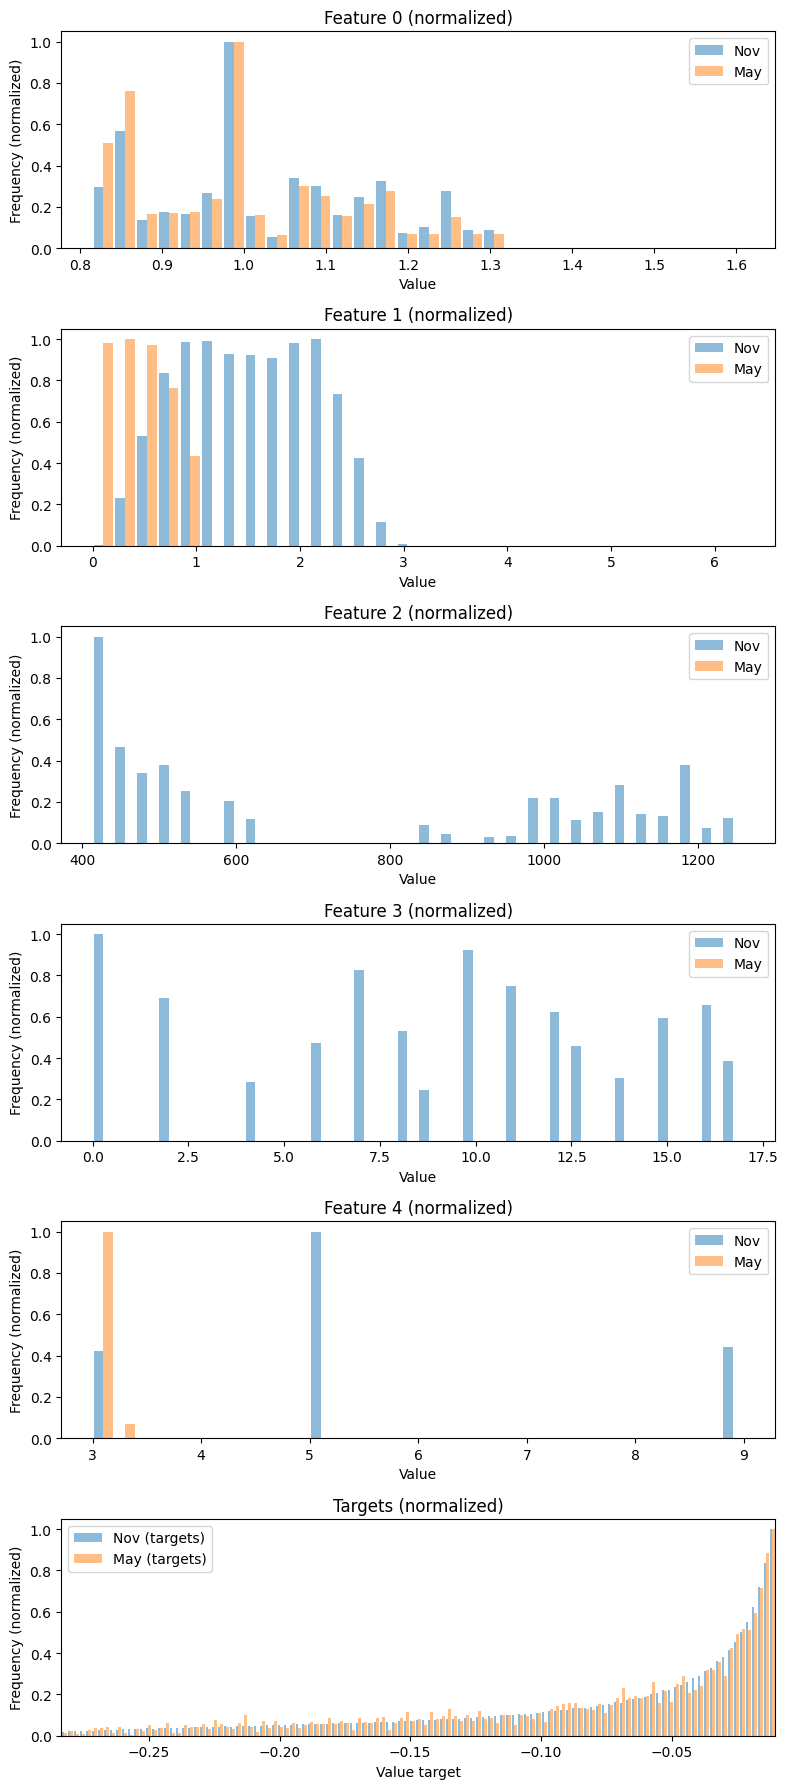

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_histograms_features_and_targets(dataset1, dataset2, label1='Nov', label2='May', bins=30):
    # Concatenar las matrices de características de cada dataset (a nivel de nodo)
    x1_all = torch.cat([data.x for data in dataset1], dim=0)
    x2_all = torch.cat([data.x for data in dataset2], dim=0)
    num_features = x1_all.shape[1]
    
    # Extraer los targets (se asume que data.y es escalar)
    y1_all = torch.tensor([data.y.item() for data in dataset1])
    y2_all = torch.tensor([data.y.item() for data in dataset2])
    
    # Se usará una fila extra para los targets
    total_rows = num_features + 1
    fig, axs = plt.subplots(total_rows, 1, figsize=(8, 3 * total_rows))
    if total_rows == 1:
        axs = [axs]
    
    for i in range(num_features):
        feat1 = x1_all[:, i].cpu().numpy()
        feat2 = x2_all[:, i].cpu().numpy()
        
        # Calcular histogramas para ambos utilizando los mismos límites.
        hist1, bin_edges = np.histogram(feat1, bins=bins)
        hist2, _ = np.histogram(feat2, bins=bin_edges)
        
        # Normalizar cada histograma dividiendo por su máximo (si es distinto de 0)
        hist1_norm = hist1 / hist1.max() if hist1.max() != 0 else hist1
        hist2_norm = hist2 / hist2.max() if hist2.max() != 0 else hist2
        
        centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
        width = (bin_edges[1] - bin_edges[0]) * 0.45  # ancho de las barras
        
        # Dibujar ambos histogramas en el mismo eje
        axs[i].bar(centers - width/2, hist1_norm, width=width, alpha=0.5, label=label1)
        axs[i].bar(centers + width/2, hist2_norm, width=width, alpha=0.5, label=label2)
        axs[i].set_title(f'Feature {i} (normalized)')
        axs[i].set_xlabel('Value')
        axs[i].set_ylabel('Frequency (normalized)')
        axs[i].legend()
    
    # Graficar los targets en la última fila
    # Calcular percentiles para limitar el rango del eje x (por ejemplo, 1% y 99%)
    y1_np = y1_all.cpu().numpy()
    y2_np = y2_all.cpu().numpy()
    y_all = np.concatenate([y1_np, y2_np])
    lower, upper = np.percentile(y_all, [1, 99])

    # Calcular histogramas usando solo los valores dentro del rango seleccionado
    hist1, bin_edges = np.histogram(y1_np[(y1_np >= lower) & (y1_np <= upper)], bins="auto", range=(lower, upper))
    hist2, _ = np.histogram(y2_np[(y2_np >= lower) & (y2_np <= upper)], bins=bin_edges)
    hist1_norm = hist1 / hist1.max() if hist1.max() != 0 else hist1
    hist2_norm = hist2 / hist2.max() if hist2.max() != 0 else hist2
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
    width = (bin_edges[1] - bin_edges[0]) * 0.45
    axs[num_features].bar(centers - width/2, hist1_norm, width=width, alpha=0.5, label=label1 + ' (targets)')
    axs[num_features].bar(centers + width/2, hist2_norm, width=width, alpha=0.5, label=label2 + ' (targets)')
    axs[num_features].set_title('Targets (normalized)')
    axs[num_features].set_xlabel('Value target')
    axs[num_features].set_ylabel('Frequency (normalized)')
    axs[num_features].set_xlim(lower, upper)
    axs[num_features].legend()
    
    plt.tight_layout()
    plt.show()

# Ejemplo de uso:
# 
plot_histograms_features_and_targets(Graphs_for_training_filtered_nov, Graphs_for_training_filtered_may)

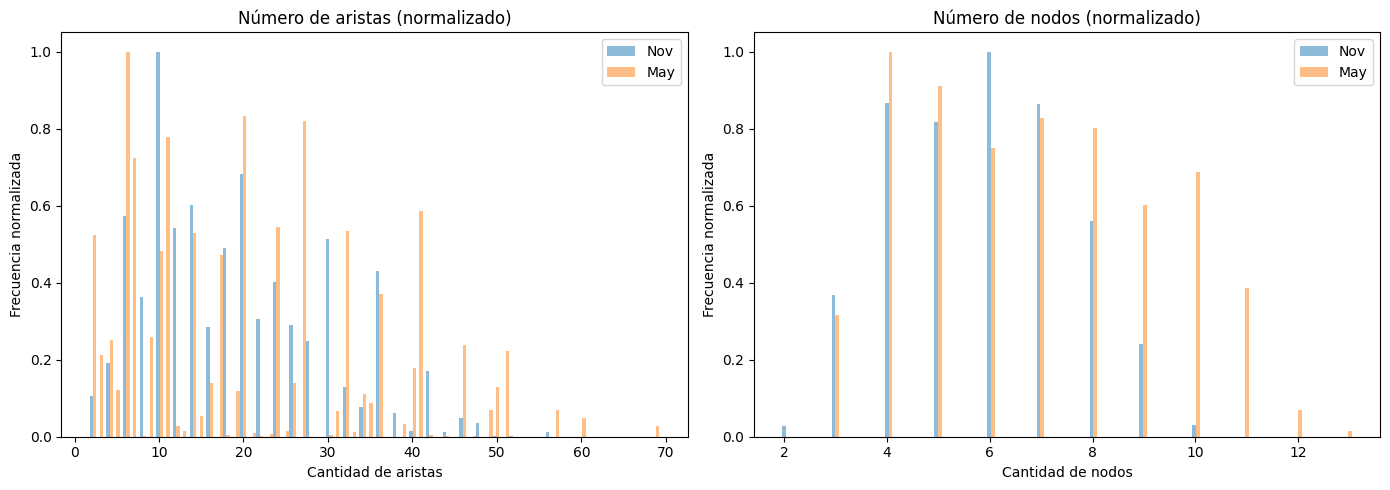

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_edges_and_nodes_histogram(dataset1, dataset2, label1="Dataset1", label2="Dataset2"):
    # Extraer el número de aristas y nodos de cada grafo
    edges1 = np.array([data.edge_index.shape[1] for data in dataset1])
    edges2 = np.array([data.edge_index.shape[1] for data in dataset2])
    nodes1 = np.array([data.x.shape[0] for data in dataset1])
    nodes2 = np.array([data.x.shape[0] for data in dataset2])

    # Calcular bins comunes para aristas
    all_edges = np.concatenate([edges1, edges2])
    _, bin_edges_edges = np.histogram(all_edges, bins="auto")
    centers_edges = (bin_edges_edges[:-1] + bin_edges_edges[1:]) / 2.

    # Calcular histogramas para aristas
    hist1_edges, _ = np.histogram(edges1, bins=bin_edges_edges)
    hist2_edges, _ = np.histogram(edges2, bins=bin_edges_edges)
    hist1_edges_norm = hist1_edges / hist1_edges.max() if hist1_edges.max() != 0 else hist1_edges
    hist2_edges_norm = hist2_edges / hist2_edges.max() if hist2_edges.max() != 0 else hist2_edges
    width_edges = (bin_edges_edges[1] - bin_edges_edges[0])

    # Calcular bins comunes para nodos
    all_nodes = np.concatenate([nodes1, nodes2])
    _, bin_edges_nodes = np.histogram(all_nodes, bins="auto")
    centers_nodes = (bin_edges_nodes[:-1] + bin_edges_nodes[1:]) / 2.

    # Calcular histogramas para nodos
    hist1_nodes, _ = np.histogram(nodes1, bins=bin_edges_nodes)
    hist2_nodes, _ = np.histogram(nodes2, bins=bin_edges_nodes)
    hist1_nodes_norm = hist1_nodes / hist1_nodes.max() if hist1_nodes.max() != 0 else hist1_nodes
    hist2_nodes_norm = hist2_nodes / hist2_nodes.max() if hist2_nodes.max() != 0 else hist2_nodes
    width_nodes = (bin_edges_nodes[1] - bin_edges_nodes[0])

    # Crear figura con dos subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot aristas
    axs[0].bar(centers_edges - width_edges/2, hist1_edges_norm, width=width_edges, alpha=0.5, label=label1)
    axs[0].bar(centers_edges + width_edges/2, hist2_edges_norm, width=width_edges, alpha=0.5, label=label2)
    axs[0].set_title("Número de aristas (normalizado)")
    axs[0].set_xlabel("Cantidad de aristas")
    axs[0].set_ylabel("Frecuencia normalizada")
    axs[0].legend()

    # Plot nodos
    axs[1].bar(centers_nodes - width_nodes/2, hist1_nodes_norm, width=width_nodes, alpha=0.5, label=label1)
    axs[1].bar(centers_nodes + width_nodes/2, hist2_nodes_norm, width=width_nodes, alpha=0.5, label=label2)
    axs[1].set_title("Número de nodos (normalizado)")
    axs[1].set_xlabel("Cantidad de nodos")
    axs[1].set_ylabel("Frecuencia normalizada")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_edges_and_nodes_histogram(Graphs_for_training_filtered_nov, Graphs_for_training_filtered_may, label1="Nov", label2="May")


In [ ]:
from torch_geometric.transforms import BaseTransform, Compose

class NormalizeNodeFeatures(BaseTransform):
    def __call__(self, data):
        if hasattr(data, 'x'):
            data.x = (data.x - data.x.mean(dim=0)) / data.x.std(dim=0)
        return data

class NormalizeEdgeFeatures(BaseTransform):
    def __call__(self, data):
        if hasattr(data, 'edge_attr'):
            data.edge_attr = (data.edge_attr - data.edge_attr.mean(dim=0)) / data.edge_attr.std(dim=0)
        return data

class NormalizeTargets(BaseTransform):
    def __call__(self, data):
        if hasattr(data, 'y'):
            data.y = (data.y - data.y.mean(dim=0)) / data.y.std(dim=0)
        return data

class DropLastTwoNodeFeatures(BaseTransform):
    def __call__(self, data):
        if hasattr(data, 'x'):
            data.x = data.x[:, :-2]  # Eliminar las dos últimas columnas
        return data

class NormalizeSpecificNodeFeatures(BaseTransform):
    def __init__(self, column_indices):
        self.column_indices = column_indices

    def __call__(self, data):
        if hasattr(data, 'x'):
            for column_index in self.column_indices:
                column = data.x[:, column_index]
                mean = column.mean()
                std = column.std()
                data.x[:, column_index] = (column - mean) / std
        return data

# Definir las transformaciones
NormalizeNodeEdgesAndDropTwoFeatures = Compose([
    NormalizeNodeFeatures(),
    NormalizeEdgeFeatures(),
    DropLastTwoNodeFeatures()  # Aplicar la transformación para eliminar las dos últimas características
])